In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# This is an exploratory cell. Not required for the project and can be safely skipped.
for field in inspect(engine).get_columns('measurement'):
    print(field['name'], field['type'])
    #print(field.keys())
#session.query(Measurement).column_descriptions
#engine.execute("select min(date), max(date) from measurement limit 10").fetchall()


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


## Thoughts on "1 year ago" statement
The last date unit (monthly or daily) can and most likely is not comlplete because the measurements could stop in the middle of the day (month). So for the consistency of the data it might make sense to exclude the last unit (day or month) from the data set. Hence the strict "less than" operator on the upper end's filter.

### Monthly vs. daily
First I tried to get the last 12 months of precipitation, or exactly 12 data points, to draw the bar chart. But then saw that it doesn't match the example plot and there is "1 year ago" in the requirements so I changed the the date format of the query to catch the daily granularity. Please don't mind the "first_month" and "last_month" variable names. They are actally at days precision if the date format is '%Y-%m-%d'.

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
d_format = '%Y-%m-%d'
first_month = session.query(
    func.strftime(d_format,
    func.date(func.max(Measurement.date), '-1 year')
)).first()[0]
last_month = session.query(
    func.strftime(d_format,
    func.max(Measurement.date)
)).first()[0]
print(f"From {first_month} to {last_month}")

# Perform a query to retrieve the data and precipitation scores
# We take the max(date) so the last month can be incomplete month, let's exclude it
sel = [func.strftime(d_format, Measurement.date), func.avg(Measurement.prcp)]
twelve_months = session.query(*sel).\
    filter(func.strftime(d_format, Measurement.date) >= first_month).\
    filter(func.strftime(d_format, Measurement.date) <  last_month).\
    group_by(func.strftime(d_format, Measurement.date)).\
    order_by(func.strftime(d_format, Measurement.date)).\
    all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(twelve_months, columns=['Date', 'Prcp']).set_index('Date')

# Sort the dataframe by date
df.sort_index(inplace=True)

df.head()


From 2016-08-23 to 2017-08-23


,Prcp
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


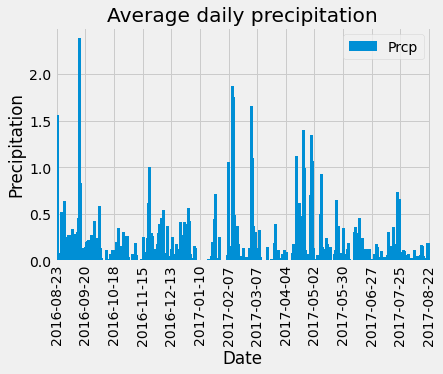

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
xticks_loc = np.arange(0, df.index.size, 28)
fig = plt.figure(figsize=(10, 6), dpi=200)
df.plot.bar(width=3)
plt.title("Average daily precipitation")
plt.ylabel("Precipitation")
plt.xticks(ticks = xticks_loc, labels= df.index[xticks_loc])
#plt.savefig('OneYearDailyAverage.png', bbox_inches='tight')
fig.show()
plt.close(fig)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Prcp
count,365.000000
mean,0.170862
std,0.296082
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


## Number of stations
We have two potential sources of the number of stations in the dataset:
* Stations table
* Measurements table

Easiest would be to simply count the number of records in the Stations table but it can potentially have less or more stations than the actual number of stations where we have the measurements from. So more precise number will be from Measurements table if we group the records by station. From the groupped by dataset we can also extract when the measurements started and ended for each station as a bonus.

In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station, func.min(Measurement.date), func.max(Measurement.date)) \
    .group_by(Measurement.station) \
    .order_by(Measurement.station) \
    .all()
print(pd.DataFrame(stations, columns=['station_id', 'start_date', 'end_date']))
print("Number of stations: ", len(stations))


station_id  start_date    end_date
0  USC00511918  2010-01-01  2015-10-30
1  USC00513117  2010-01-01  2017-07-31
2  USC00514830  2010-03-01  2017-08-23
3  USC00516128  2010-01-01  2017-08-23
4  USC00517948  2010-05-03  2017-07-31
5  USC00518838  2010-01-01  2015-11-20
6  USC00519281  2010-01-01  2017-08-18
7  USC00519397  2010-01-01  2017-08-23
8  USC00519523  2010-01-01  2017-08-23
Number of stations:  9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_measurements = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()
station_measurements

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
active_station = station_measurements[0][0]
active_station

'USC00519281'

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
(tmin, tavg, tmax) = session.query(
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs),
    func.max(Measurement.tobs)
).filter(Measurement.station == active_station) \
 .first()
print("Lowest  temperature:", tmin)
print("Average temperature:", tavg)
print("Highest temperature:", tmax)

Lowest  temperature: 54.0
Average temperature: 71.66378066378067
Highest temperature: 85.0


In [18]:
# Choose the station with the highest number of temperature observations.
(most_station, mstation_name, ntemps) = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)) \
    .filter(Measurement.station == Station.station) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.tobs).desc()) \
    .first()
print("Station with most temp measurements:", most_station, mstation_name)

Station with most temp measurements: USC00519281 WAIHEE 837.5, HI US


From 2016-08-18 to 2017-08-18


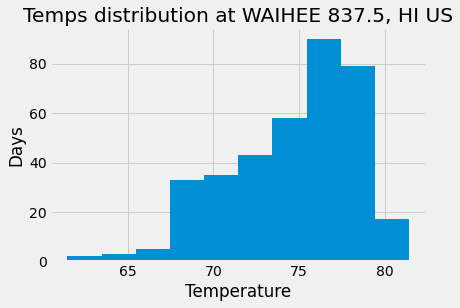

In [19]:

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
d_format = '%Y-%m-%d'
first_month = session.query(
    func.strftime(d_format,
    func.date(func.max(Measurement.date), '-1 year')
)).filter(Measurement.station == most_station).first()[0]
last_month = session.query(
    func.strftime(d_format,
    func.max(Measurement.date)
)).filter(Measurement.station == most_station).first()[0]
print(f"From {first_month} to {last_month}")

# Perform a query to retrieve the data and precipitation scores
# We take the max(date) so the last month can be incomplete month, let's exclude it
sel = [func.strftime(d_format, Measurement.date), func.avg(Measurement.tobs)]
twelve_months = session.query(*sel).\
    filter(func.strftime(d_format, Measurement.date) >= first_month).\
    filter(func.strftime(d_format, Measurement.date) <  last_month).\
    group_by(func.strftime(d_format, Measurement.date)).\
    order_by(func.strftime(d_format, Measurement.date)).\
    all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(twelve_months, columns=['Date', 'Temp']).set_index('Date')

# Sort the dataframe by date
df.sort_index(inplace=True)

df.hist()
plt.title(f"Temps distribution at {mstation_name}")
plt.xlabel("Temperature")
plt.ylabel("Days")
#plt.savefig('OneYearTemparatureHistogram.png', bbox_inches='tight', dpi=100)
plt.show()


## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2012-12-25', '2012-12-31'))
print(calc_temps('2013-12-25', '2013-12-31'))

[(62.0, 69.5, 78.0)]
[(64.0, 71.66, 79.0)]


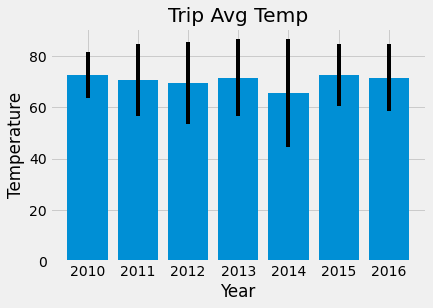

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
years = (2010, 2011, 2012, 2013, 2014, 2015, 2016,)

# Let's go to Hawaii for the Holidays
yval = []
yerr = []
for year in years:
    start_dt = f"{year}-12-25"
    end_dt = f"{year}-12-31"
    tmin, tavg, tmax = calc_temps(start_dt, end_dt)[0]
    #print(year, tmin, tavg, tmax)
    yval += [tavg]
    yerr += [(tmax - tmin)]
plt.bar(years, yval, yerr=yerr)
plt.title("Trip Avg Temp")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
result = session.query(
    Measurement.station,
    func.sum(Measurement.prcp),
    Station.name,
    Station.latitude,
    Station.longitude,
    Station.elevation) \
.filter(Measurement.date >= '2014-12-25') \
.filter(Measurement.date <= '2014-12-31') \
.filter(Measurement.station == Station.station) \
.group_by(Measurement.station) \
.order_by(func.sum(Measurement.prcp).desc()) \
.all()

pd.DataFrame(result, columns=[
    'Station',
    'Precipitation',
    'Station Name',
    'Latitude',
    'Longitude',
    'Elevation',
    ])

,Station,Precipitation,Station Name,Latitude,Longitude,Elevation
0,USC00519523,1.16,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,USC00519281,1.02,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,0.81,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00511918,0.70,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
4,USC00519397,0.07,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00516128,0.03,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
6,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9
7,USC00514830,NaN,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_dt = dt.date(2020, 12, 25)
end_dt = dt.date(2021, 1, 1)
# Use the start and end date to create a range of dates
days = np.arange(start_dt, end_dt)
# Stip off the year and save a list of %m-%d strings
stripped_days = [d.item().strftime("%m-%d") for d in days]
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normal = [daily_normals(x)[0] for x in stripped_days]
daily_normal

[(60.0, 71.75, 79.0),
 (63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0),
 (62.0, 70.52083333333333, 77.0),
 (57.0, 70.29166666666667, 78.0),
 (63.0, 69.86363636363636, 76.0),
 (56.0, 68.27906976744185, 77.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temps = pd.DataFrame(daily_normal, columns=['Min', 'Avg', 'Max'])
trip_temps['trip_dates'] = days
trip_temps.set_index('trip_dates', inplace=True)
trip_temps

,Min,Avg,Max
trip_dates,,,
2020-12-25,60.0,71.750000,79.0
2020-12-26,63.0,71.446809,77.0
2020-12-27,62.0,71.916667,79.0
2020-12-28,62.0,70.520833,77.0
2020-12-29,57.0,70.291667,78.0
2020-12-30,63.0,69.863636,76.0
2020-12-31,56.0,68.279070,77.0


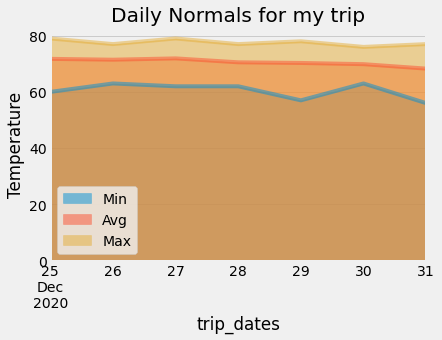

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
trip_temps.plot(kind='area', stacked=False)
plt.title("Daily Normals for my trip")
plt.ylabel("Temperature")
plt.show()